# SECTION 1: Mount Google Drive & Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# Set Kaggle JSON for API access
kaggle_json_path = '/content/drive/MyDrive/Pytorch_projects/kaggle.json'
os.environ['KAGGLE_CONFIG_DIR'] = os.path.dirname(kaggle_json_path)
!chmod 600 {kaggle_json_path}  # Secure the API key

In [3]:
# Download and unzip dataset from Kaggle
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [4]:
# Import necessary libraries
import pandas as pd  # For data manipulation
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.metrics import confusion_matrix, classification_report  # For model evaluation
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For plotting
import re  # For regular expressions
import numpy as np  # For numerical operations
import tensorflow as tf  # For deep learning
from tensorflow.keras.models import Sequential, load_model  # For creating and loading models
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, SpatialDropout1D, Bidirectional  # For model layers
from tensorflow.keras.preprocessing.text import Tokenizer  # For text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For padding sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau  # For training callbacks



# SECTION 2: Load & Preprocess Dataset

In [5]:
# Load CSV into DataFrame
df = pd.read_csv('/content/IMDB Dataset.csv')

In [6]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
# Encode labels
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [9]:
# Define a text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"<.*?>", " ", text)  # Remove HTML
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", " ", text)  # Remove digits
    text = re.sub(r"\s+", " ", text).strip()  # Trim whitespaces
    return text

In [10]:
# Apply cleaning to review text
df['clean_review'] = df['review'].apply(preprocess_text)

# Take a look at the cleaned data
df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love in the time of money is a ...


# SECTION 3: Tokenization and Padding

In [11]:
# Initialize tokenizer with 10k vocab size
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_review'])

In [12]:
# Convert text to sequences and pad them
X = tokenizer.texts_to_sequences(df['clean_review'])
X = pad_sequences(X, padding='post', truncating='post', maxlen=200)

# Check the shape of the resulting data
X.shape

(50000, 200)

In [13]:
# Target variable
y = np.array(df['sentiment'])

# SECTION 4: Data Splitting

In [14]:
# Split into train (70%), val (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Test Data Shape:", X_test.shape)

Training Data Shape: (35000, 200)
Validation Data Shape: (7500, 200)
Test Data Shape: (7500, 200)


# SECTION 5: Build the RNN Model

In [29]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=200, trainable=True))  # Embedding layer
model.add(SpatialDropout1D(0.3))  # Dropout for embedding
model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))  # Bi-RNN layer 1
model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))  # Bi-RNN layer 2
model.add(SimpleRNN(32))  # Simple RNN to reduce sequence
model.add(Dropout(0.5))  # Regular dropout
model.add(Dense(64, activation='relu'))  # Dense layer
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Explicitly build the model to initialize the weights and output shapes
model.build(input_shape=(None, 200))

# Display the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 200, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,336,737 (5.10 MB)

 Trainable params: 1,336,737 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

# SECTION 6: Define Callbacks

In [31]:
# Create a ReduceLROnPlateau callback to adjust learning rate during training.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Quantity to monitor (validation loss).
    factor=0.5,          # Factor by which to reduce the learning rate (halved).
    patience=2,          # Number of epochs with no improvement after which to reduce LR.
    verbose=1,          # Print a message when LR is reduced.
    min_lr=1e-6         # Lower bound on the learning rate.
)

In [32]:
# Early stopping to stop training when the validation loss is not decreasing
early_stopping = EarlyStopping(
    monitor='val_loss',  # Quantity to monitor (validation loss)
    patience=4,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

In [33]:
# Define the filepath to save the model
model_save_path = '/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/BiRNN.h5'

# Save the best model based on validation loss
checkpoint = ModelCheckpoint(
    filepath=model_save_path,  # Filepath to save the model (now using the variable)
    monitor='val_loss',        # Quantity to monitor (validation loss)
    save_best_only=True,      # Save only the best model
    verbose=1                  # Verbosity mode
)

In [34]:
# CSVLogger to log training history in CSV format
log_file_path = "/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Logs/BiRNN_training_log.csv"  # Define the file path for the log file
csv_logger = CSVLogger(
    log_file_path,  # Filepath to save the log
    append=True      # Append to existing file if it exists
)

# SECTION 7: Model Training

In [35]:
# Train the model
history = model.fit(
    X_train, y_train,                # Training data (input features and target labels)
    epochs=100,                      # Number of training epochs
    batch_size=64,                    # Batch size for training
    validation_data=(X_val, y_val),  # Validation data for monitoring performance
    callbacks=[checkpoint, early_stopping, csv_logger,reduce_lr]  # List of callbacks to use during training
)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5021 - loss: 0.7146
Epoch 1: val_loss improved from inf to 0.69389, saving model to /content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/BiRNN.h5


547/547 ━━━━━━━━━━━━━━━━━━━━ 63s 95ms/step - accuracy: 0.5021 - loss: 0.7146 - val_accuracy: 0.4864 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5032 - loss: 0.6953
Epoch 2: val_loss improved from 0.69389 to 0.69339, saving model to /content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/BiRNN.h5


547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.5032 - loss: 0.6953 - val_accuracy: 0.4919 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5002 - loss: 0.6936
Epoch 3: val_loss did not improve from 0.69339
547/547 ━━━━━━━━━━━━━━━━━━━━ 44s 80ms/step - accuracy: 0.5002 - loss: 0.6936 - val_accuracy: 0.4919 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5007 - loss: 0.6938
Epoch 4: val_loss improved from 0.69339 to 0.69314, saving model to /content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/BiRNN.h5


547/547 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.5007 - loss: 0.6938 - val_accuracy: 0.4919 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5040 - loss: 0.6932
Epoch 5: val_loss improved from 0.69314 to 0.69262, saving model to /content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/BiRNN.h5


547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.5040 - loss: 0.6932 - val_accuracy: 0.4920 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5012 - loss: 0.6945
Epoch 6: val_loss did not improve from 0.69262
547/547 ━━━━━━━━━━━━━━━━━━━━ 44s 80ms/step - accuracy: 0.5012 - loss: 0.6945 - val_accuracy: 0.4955 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5087 - loss: 0.6928
Epoch 7: val_loss improved from 0.69262 to 0.69255, saving model to /content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/BiRNN.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
547/547 ━━━━━━━━━━━━━━━━━━━━ 84s 84ms/step - accuracy: 0.5087 - loss: 0.6928 - val_accuracy: 0.5009 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 8/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5318 - loss: 0.6880
Epoch 8: val_loss did not improve from 0.69255
547/547 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.5318 - loss: 0.6880 - val_accuracy: 0.5028 - val_loss: 0.6935 - learning_rate: 5.0000e-04
Epoch 9/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5362 - loss: 0.6842
Epoch 9: val_loss did not improve from 0.69255

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
547/547 ━━━━━━━━━━━━━━━━━━━━ 44s 80ms/step - accuracy: 0.5362 - loss: 0.6842 - val_accuracy: 0.5028 - val_loss: 0.6953 - learning_rate: 5.0000e-04
Epoch 10/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5443 - loss: 0.6796
Epoch 10: val_loss did not improve from 0.69255
54

# SECTION 8: Plot Training History

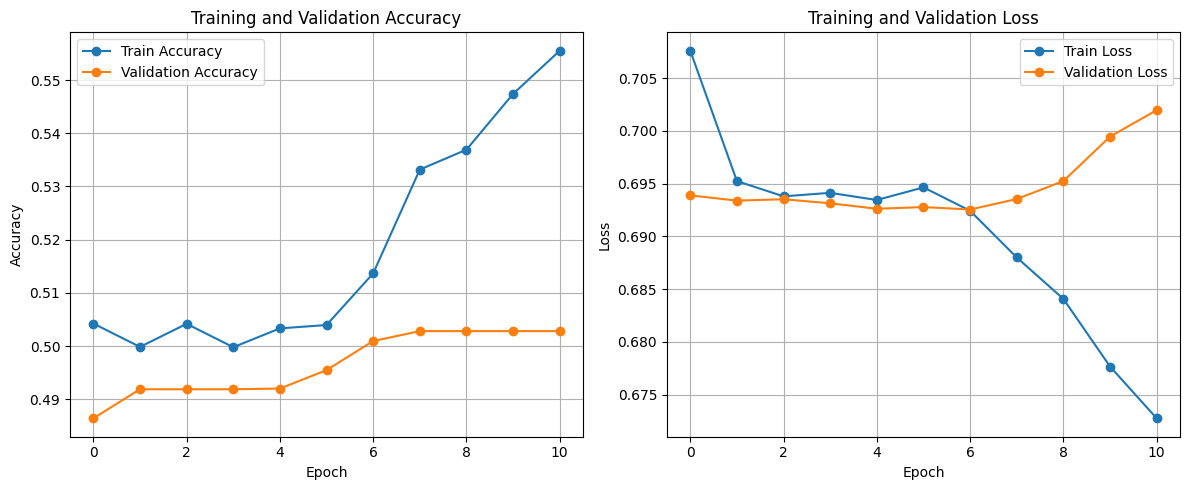

In [36]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [24]:

# Load the full model (architecture + weights + optimizer state)
#model = load_model('/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/imdb_best_model.h5')

# Check if it's loaded properly
#model.summary()


# SECTION 9: Model Evaluation & Confusion Matrix

In [40]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predicting with the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

Test Accuracy: 50.55%
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


In [41]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.93      0.65      3722
           1       0.56      0.08      0.14      3778

    accuracy                           0.51      7500
   macro avg       0.53      0.51      0.40      7500
weighted avg       0.53      0.51      0.40      7500



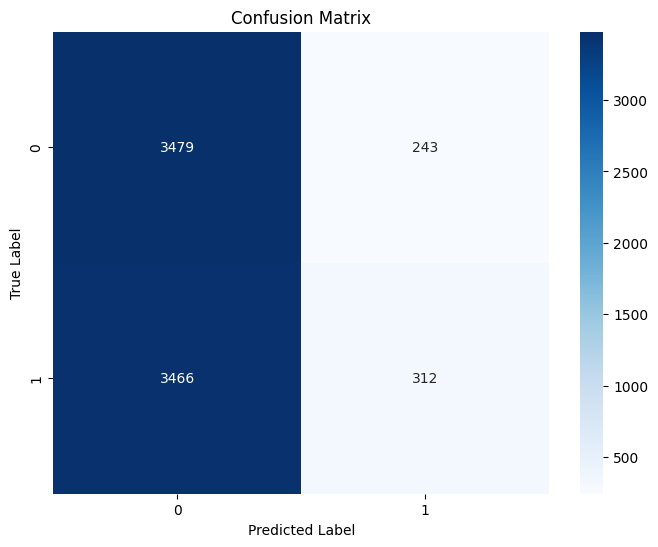

In [42]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()